In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.pipeline_utils.file_utils import get_date
from transformations.grid_transformation import Transformation

In [2]:
ds_name = "AQUARIUS_L3_SSS_SMI_MONTHLY_V5"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/AQUARIUS_L3_SSS_SMI_MONTHLY_V5/harvested_granules/2012/Q20120922012121.L3m_MO_SCI_V5.0_SSS_1deg.bz2.nc4


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:      (dim1: 180, dim2: 360, dim3: 180, dim4: 360, dim5: 180,
                  dim6: 360, dim7: 3, dim8: 256)
Dimensions without coordinates: dim1, dim2, dim3, dim4, dim5, dim6, dim7, dim8
Data variables:
    SSS          (dim1, dim2) float32 ...
    SSS_ran_unc  (dim3, dim4) float32 ...
    SSS_sys_unc  (dim5, dim6) float32 ...
    palette      (dim7, dim8) int16 ...
Attributes: (12/68)
    product_name:                      Q20120922012121.L3m_MO_SCI_V5.0_SSS_1deg
    instrument:                        Aquarius
    title:                             Aquarius Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          SAC-D Aquarius
    temporal_range:                    MO
    ...                                ...
    identifier_product_doi:            http://dx.doi.org
    keywords:                          SURFACE SALINITY, SALINITY, AQUARIUS, ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    software_name:                     smigen
    software_version:                  5.20
    source:                            Q20120922012121.L3b_MO_SCI_V5.0.main

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

# Transformation

In [10]:
field_ds_list = T.transform(grid_ds, factors, ds)

In [11]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                         (time: 1, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2012-04-16
  * tile                            (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                               (j) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
  * i                               (i) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
    XC                              (tile, j, i) float32 -111.6 ... -111.9
    YC                              (tile, j, i) float32 -88.24 -88.38 ... -88.1
    time_bnds                       (time, nv) datetime64[ns] 2012-04-01 2012...
Dimensions without coordinates: nv
Data variables:
    SSS_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969e+36 ... ...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       Aquarius Official Release Level 3 Sea Surfa...
    original_dataset_short_name:  AQUARIUS_L3_SSS_SMI_MONTHLY_V5
    original_dataset_url:         https://podaac.jpl.nasa.gov/dataset/AQUARIU...
    original_dataset_reference:   https://aquarius.nasa.gov/
    original_dataset_doi:         10.5067/AQR50-3SMCS
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.0
    notes:

# Visualization

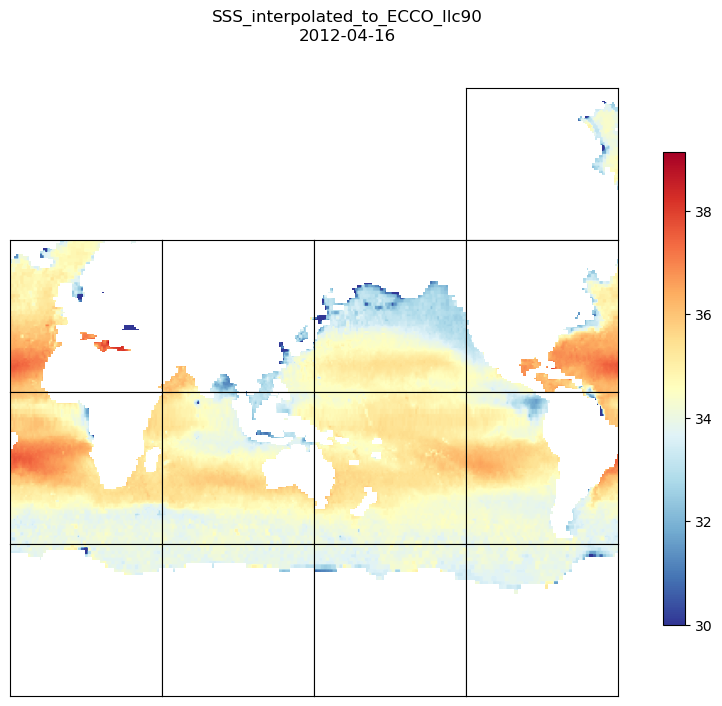

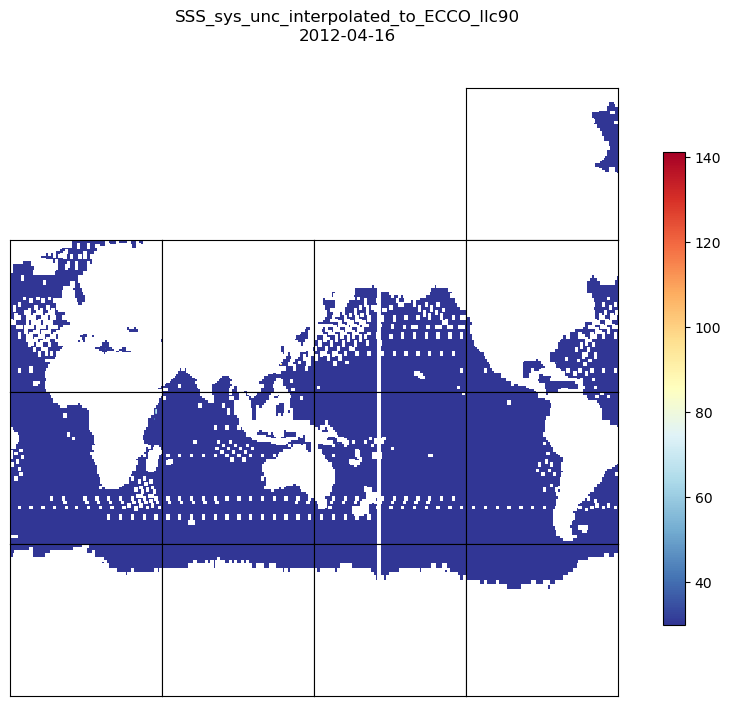

In [12]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], vmin=30)
